# <center> <span style="color:indigo">       Deep Learning</span> </center> 
##  <center> <span style="color:DarkBlue">       Tarea 4.  RNN para el análisis de sentimientos en tweets </span>  </center>
##  <center> <span style="color:DarkBlue"> Karla Guadalupe Ornelas Gamero</span>  </center>
##  <center> <span style="color:DarkBlue"> karla.gameroo@gmail.com</span>  </center>
##  <center> <span style="color:DarkBlue"> agosto 2024</span>  </center>

##  Contenido
1. <span style="color:DarkBlue">Planteamiento del problema (qué hacer)</span>
2. <span style="color:DarkBlue">Planteamiento de la solución (cómo se hizó)</span>
3. <span style="color:DarkBlue">Ejemplo de ejecución (código)</span>
4. <span style="color:DarkBlue">Conclusiones </span>
5. <span style="color:DarkBlue">Referencias</span>


## <span style="color:DarkBlue"> 1. Planteamiento del problema</span>
Usando la libreta de sentimientos (enojo, alegría, neutralidad, etc.)  con la RNN (explicada en la sesión 6 y 7), deberá realizar lo siguiente:  
Usar el dataset airlines_tweets.zip para realizar un análisis de sentimientos.       
Crear un modelo de RNN entrenado para hacer clasificación multiclase.
Hacer un par de pruebas con textos de su autoría y hacer un reporte de los resultad
## <span style="color:DarkBlue">2. Planteamiento de la solución</span>
El proceso de solucion primero que nada seria analizar el dataset explorandolo , despues procesaremos los datos para mas adelante contruir el modelo y entrenarlo. Por ultimo agarraremos tweets al alzar para realizar pruebas sobre ellos 
os. 

El código es:


### Importamos Librerias

In [41]:
import warnings
warnings.filterwarnings('ignore')
import re
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam,SGD,RMSprop  
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import GRU

### Una RNN son algoritmos que sirven para datos secuenciales normalmente utilizados en NLP que es el procesamiento del lenguaje natural 



In [42]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Karla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Karla\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

 ### Path del data set

In [43]:
Path = "airlines_tweets/" #Depende de la ruta en tu máquina

In [44]:
os.listdir(Path)

['database.sqlite', 'Tweets.csv']

### Contenido
El dataset contiene tweet referente a criticas de aerolineas, estan clasificadas por positivas , negativas y neutrales 
Las columnas mas relevantes principalmente son  airline_sentiment y text que indica si un tweet fue positivo negativo o neutral, y el texto que basicamente es el contenido del texto
Algunos otros que pueden ser relevantes pero no necesarios para este anilisi es  airline_sentiment_confidence, negativereason y  retweet_count ya que nos da mas descripcion acerca del tweet pero en esta ocasion no lo necesitaremos 

In [45]:
df = pd.read_csv(Path + "Tweets.csv")
df = df[['airline_sentiment', 'text', 'airline_sentiment_confidence', 'negativereason', 'retweet_count']]
df.head()

,airline_sentiment,text,airline_sentiment_confidence,negativereason,retweet_count
0,neutral,@VirginAmerica What @dhepburn said.,1.0000,NaN,0
1,positive,@VirginAmerica plus you've added commercials t...,0.3486,NaN,0
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0.6837,NaN,0
3,negative,@VirginAmerica it's really aggressive to blast...,1.0000,Bad Flight,0
4,negative,@VirginAmerica and it's a really big bad thing...,1.0000,Can't Tell,0


 Checamos si no hay datos faltantes

In [46]:
df["airline_sentiment"].isnull().any() 
df.text.isnull().any()

False

 ### Limpieza del dataset
- Se eliminara puntuaciones, caracteres especiales y  stopwords


In [47]:
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_specialchars(text):
    return re.sub("[^a-zA-Z0-9]"," ",text)

def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower() #convert all words into lowercase
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)


def cleaning(text):
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

df['text']=df['text'].apply(cleaning)

In [48]:
df.head()

,airline_sentiment,text,airline_sentiment_confidence,negativereason,retweet_count
0,neutral,virginamerica dhepburn said,1.0000,NaN,0
1,positive,virginamerica plus added commercial experience...,0.3486,NaN,0
2,neutral,virginamerica today must mean need take anothe...,0.6837,NaN,0
3,negative,virginamerica really aggressive blast obnoxiou...,1.0000,Bad Flight,0
4,negative,virginamerica really big bad thing,1.0000,Can't Tell,0


Agregaremos tres columnas mas que nos proporcionara informacion extra, porque ejemplo la cantidad de palabras en los textos y tambien si el texto digitos

En nuestro caso no propociona informacion tan escencial pero es importante realizar la limpieza de los datos 

In [49]:
df['text_count'] = df.text.apply(lambda x: len(list(x.split())))
df['text_unique_word_count'] = df.text.apply(lambda x: len(set(x.split())))
df['text_has_digits'] = df.text.apply(lambda x: bool(re.search(r'\d', x)))
df


,airline_sentiment,text,airline_sentiment_confidence,negativereason,retweet_count,text_count,text_unique_word_count,text_has_digits
0,neutral,virginamerica dhepburn said,1.0000,NaN,0,3,3,False
1,positive,virginamerica plus added commercial experience...,0.3486,NaN,0,6,6,False
2,neutral,virginamerica today must mean need take anothe...,0.6837,NaN,0,8,8,False
3,negative,virginamerica really aggressive blast obnoxiou...,1.0000,Bad Flight,0,11,11,False
4,negative,virginamerica really big bad thing,1.0000,Can't Tell,0,5,5,False
...,...,...,...,...,...,...,...,...
14635,positive,americanair thank got different flight chicago,0.3487,NaN,0,6,6,False
14636,negative,americanair leaving 20 minute late flight warn...,1.0000,Customer Service Issue,0,16,13,True
14637,neutral,americanair please bring american airline blac...,1.0000,NaN,0,6,6,True
14638,negative,americanair money change flight answer phone s...,1.0000,Customer Service Issue,0,9,9,False


### Graficaciones

#### Grafica de la frecuencia de cada sentimiento

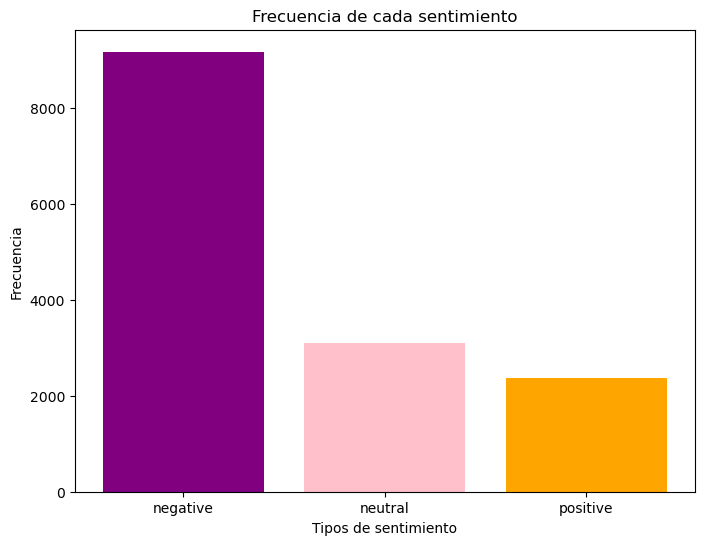

airline_sentiment
negative    0.63
neutral     0.21
positive    0.16
Name: count, dtype: float64

In [59]:


sentiment_counts = df['airline_sentiment'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['purple', 'pink', 'orange'])
plt.xlabel('Tipos de sentimiento')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de cada sentimiento')
plt.xticks(fontsize=10)
plt.show()

proportions = round(sentiment_counts / sentiment_counts.sum(), 2)
proportions


#### Grafica de razones por los comentarios negativos

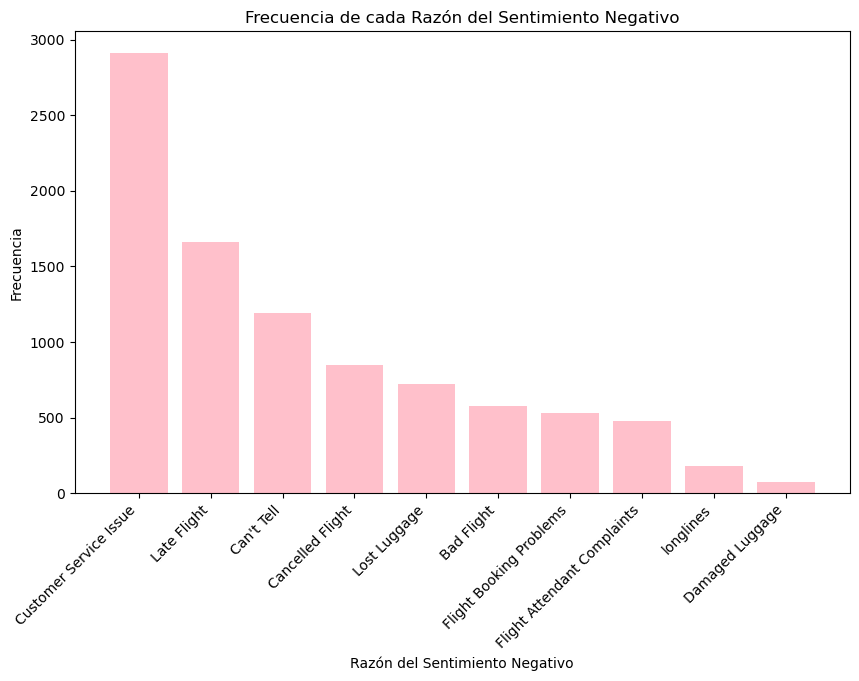

In [58]:

negative_reasons_counts = df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts()


plt.figure(figsize=(10, 6))
plt.bar(negative_reasons_counts.index, negative_reasons_counts.values, color='pink')
plt.xlabel('Razón del Sentimiento Negativo')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de cada Razón del Sentimiento Negativo')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()


#### Distribucion de la confianza en los sentimientos

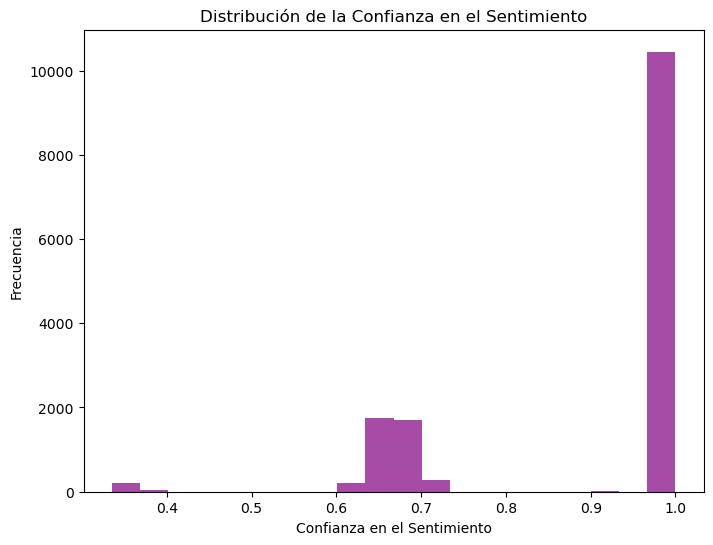

In [54]:
plt.figure(figsize=(8, 6))
plt.hist(df['airline_sentiment_confidence'], bins=20, color='purple', alpha=0.7)
plt.xlabel('Confianza en el Sentimiento')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Confianza en el Sentimiento')
plt.show()


#### Grafica de cantidad de palabras por sentimiento

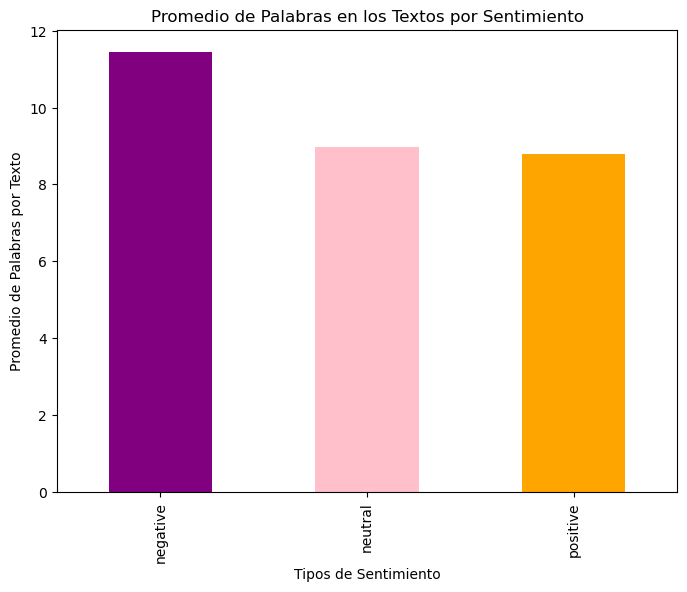

In [60]:
df.groupby('airline_sentiment')['text_count'].mean().plot(kind='bar', color=['purple', 'pink', 'orange'], figsize=(8, 6))
plt.xlabel('Tipos de Sentimiento')
plt.ylabel('Promedio de Palabras por Texto')
plt.title('Promedio de Palabras en los Textos por Sentimiento')
plt.show()


#### Grafico de dispersion para la relacion entre longitud del text y la confianza en el sentimiento

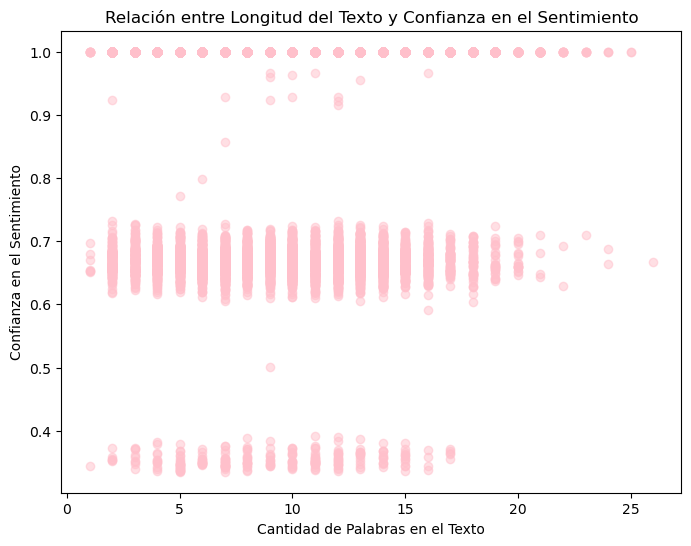

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(df['text_count'], df['airline_sentiment_confidence'], alpha=0.5, c='pink')
plt.xlabel('Cantidad de Palabras en el Texto')
plt.ylabel('Confianza en el Sentimiento')
plt.title('Relación entre Longitud del Texto y Confianza en el Sentimiento')
plt.show()


In [62]:
text = " ".join(review for review in df.text)
print ("Hay {} palabras en conjunto con todo el texto.".format(len(text)))

Hay 1038529 palabras en conjunto con todo el texto.


#### Mostrando informacion acerca del dataset

In [63]:
df.info(), sentiment_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   text                          14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   retweet_count                 14640 non-null  int64  
 5   text_count                    14640 non-null  int64  
 6   text_unique_word_count        14640 non-null  int64  
 7   text_has_digits               14640 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 815.0+ KB


(None,
 airline_sentiment
 negative    9178
 neutral     3099
 positive    2363
 Name: count, dtype: int64)

#### Division del dataset

In [64]:
train_data, test_data = train_test_split(df[['text', 'airline_sentiment']], test_size=0.2, random_state=42)

training_sentences = list(train_data['text'])
training_labels = list(train_data['airline_sentiment'])

testing_sentences = list(test_data['text'])
testing_labels = list(test_data['airline_sentiment'])

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


### Preprocesamiento de datos

Esta parte del código se encarga de preparar los datos de texto para el entrenamiento de un modelo al convertir los textos en secuencias numéricas y asegurarse de que todas las secuencias tengan una longitud uniforme. Esto es esencial para que el modelo pueda manejar las entradas de texto de manera efectiva.

- El vocab_size: Define el tamaño del vocabulario, limitando el modelo a las 10,000 palabras más frecuentes en los datos.

- El embedding_dim: Especifica la dimensión del espacio de embedding. En otras palabras, es el tamaño de los vectores que se utilizarán para representar cada palabra en el vocabulario. Cada palabra se representará como un vector de 16 valores numéricos continuos.

- El max_length: Define la longitud máxima de las secuencias de texto. Si un texto es más largo, se truncará; si es más corto, se rellenará.

- El trunc_type='post': Indica que si una secuencia de texto es más larga que max_length, se truncará desde el final 

- El tokenizer es una herramienta utilizada en el procesamiento de texto para convertir secuencias de palabras en secuencias de enteros.

- El fit_on_texts ajusta el tokenizador a las oraciones de entrenamiento para construir un índice de palabras.

- El word_index contiene un diccionario que asigna un índice único a cada palabra en el vocabulario.

- El texts_to_sequences convierte las oraciones en secuencias de enteros basadas en el índice de palabras.

- El pad_sequences asegura que todas las secuencias tengan la misma longitud (max_length). Las secuencias más cortas se rellenan con ceros y las más largas se truncan según trunc_type.
- 
- Inicialización y Ajuste del Tokenizer: Se inicializa el Tokenizer y se ajusta al conjunto de datos de entrenamiento para construir un diccionario de palabras.

- Conversión de Texto a Secuencias: Se convierte el texto en secuencias numéricas usando el Tokenizer.

- Aplicación de Padding: Se aplican técnicas de padding y truncado para que todas las secuencias tengan la misma longitud.

- Codificación de Etiquetas: Se utiliza LabelEncoder para transformar las etiquetas de texto en números enteros.

- Conversión a One-Hot Encoding: Finalmente, las etiquetas se convierten a formato one-hot, que es adecuado para la clasificación multiclase.

In [65]:

# Hiperparámetros
vocab_size = 10000  # Tamaño del vocabulario (número máximo de palabras que consideraremos)
embedding_dim = 16  # Dimensión de los vectores de embedding
max_length = 50  # Longitud máxima de las secuencias (padding)
trunc_type = 'post'  # Truncado al final de la secuencia
padding_type = 'post'  # Padding al final de la secuencia
oov_tok = "<OOV>"  # Token para palabras fuera de vocabulario
num_classes = 3  # Número de clases (positivo, negativo, neutral)

# Inicializar el Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Convertir las oraciones en secuencias
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Aplicar padding a las secuencias
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Crear un LabelEncoder y ajustarlo a las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(training_labels)

# Convertir etiquetas de texto a números enteros
training_labels_encoded = label_encoder.transform(training_labels)
testing_labels_encoded = label_encoder.transform(testing_labels)

# Convertir las etiquetas a formato one-hot
training_labels_final = to_categorical(training_labels_encoded, num_classes=num_classes)
testing_labels_final = to_categorical(testing_labels_encoded, num_classes=num_classes)

### Modelos GRU 

In [66]:


# Construcción del modelo GRU modificado
model_gru_version1 = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=False)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l1(0.003), activation='softmax')  # Cambiado para multiclase
])

# Compilación del modelo
model_gru_version1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Resumen del modelo
model_gru_version1.summary()

# Entrenamiento del modelo
num_epochs = 10
history_gru_version1 = model_gru_version1.fit(
                    training_padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    batch_size=64, 
                    validation_data=(testing_padded, testing_labels_final),
                    verbose=2
                    )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              112128    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                

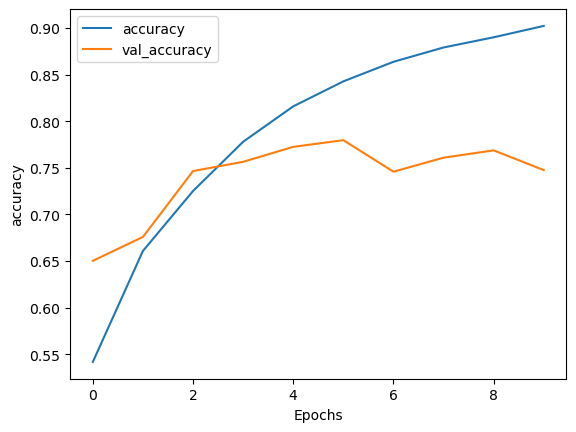

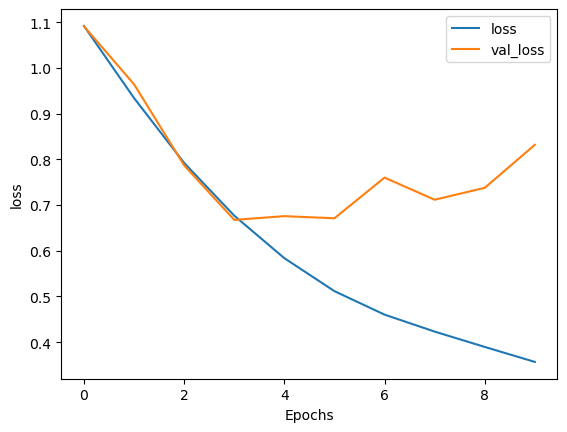

In [68]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_gru_version1, 'accuracy')
plot_graphs(history_gru_version1, 'loss')
plt.show()

Alcanzamos con esta version un 74% de precision

In [70]:

model_gru_version2 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.GRU(32)),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.003), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l1(0.003), activation='softmax')  # Cambiado para multiclase
])

# Compilación del modelo
model_gru_version2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model_gru_version2.summary()

# Entrenamiento del modelo
num_epochs = 10
history_gru_version2 = model_gru_version2.fit(
                    training_padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    batch_size=64, 
                    validation_data=(testing_padded, testing_labels_final),
                    verbose=2
                    )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 100)               6500      
                                                                 
 batch_normalization_5 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                

En esta version alcanzamos un 76%

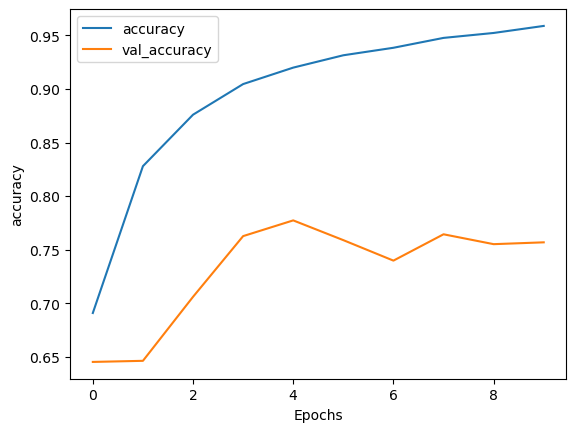

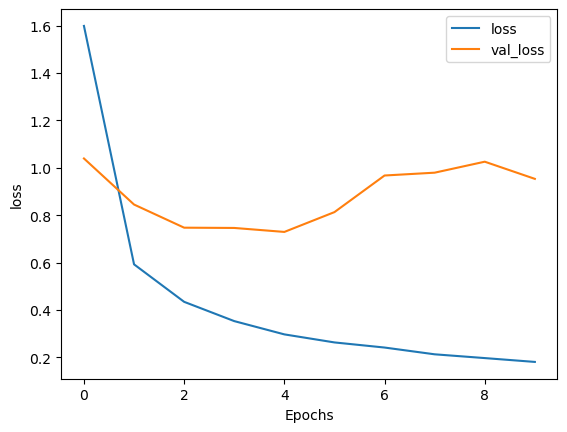

In [71]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_gru_version2, 'accuracy')
plot_graphs(history_gru_version2, 'loss')
plt.show()

In [80]:
new_texts = [
    "Just had the best flight experience with @Airline! Smooth takeoff and landing, and the service was amazing. #TravelGoals",
    "Flying with @Airline was a breeze. Comfortable seats and friendly staff made the journey enjoyable. #HappyTraveler",
    "Flight was on time, but nothing special. Just another routine trip. #Travel",
    "Awful service on my flight today. The staff were rude and the food was terrible. #DisappointedTraveler",
    "Arrived at my destination as planned. The flight was okay, no major issues. #AirportLife"
]


In [81]:
# Convertir los nuevos textos en secuencias
new_sequences = tokenizer.texts_to_sequences(new_texts)

# Aplicar padding a las secuencias
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [85]:
# Hacer predicciones
predictions = model_gru_version2.predict(new_padded)

# Convertir las predicciones en clases
predicted_classes = np.argmax(predictions, axis=1)

# Decodificar las clases numéricas a etiquetas originales
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Mostrar los resultados
for i, text in enumerate(new_texts):
    print(f"Texto: {text}")
    print(f"Sentimiento Predicho: {predicted_labels[i]}")
    print()


1/1 [==============================] - 0s 33ms/step
Texto: Just had the best flight experience with @Airline! Smooth takeoff and landing, and the service was amazing. #TravelGoals
Sentimiento Predicho: positive

Texto: Flying with @Airline was a breeze. Comfortable seats and friendly staff made the journey enjoyable. #HappyTraveler
Sentimiento Predicho: positive

Texto: Flight was on time, but nothing special. Just another routine trip. #Travel
Sentimiento Predicho: negative

Texto: Awful service on my flight today. The staff were rude and the food was terrible. #DisappointedTraveler
Sentimiento Predicho: negative

Texto: Arrived at my destination as planned. The flight was okay, no major issues. #AirportLife
Sentimiento Predicho: negative



In [94]:
new_texts = [
    "I absolutely loved the service, it was fantastic!",
    "The flight was delayed for hours, very disappointing.",
    "The seats were okay, but the food was terrible.",
    "Amazing experience, will definitely fly again!",
    "It was an average trip, nothing special.",
    "VirginAmerica I didn't today... Must mean I need to take another trip!"
]
# Convertir los nuevos textos en secuencias
new_sequences = tokenizer.texts_to_sequences(new_texts)

# Aplicar padding a las secuencias
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# Hacer predicciones
predictions = model_gru_version2.predict(new_padded)

# Convertir las predicciones en clases
predicted_classes = np.argmax(predictions, axis=1)

# Decodificar las clases numéricas a etiquetas originales
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Mostrar los resultados
for i, text in enumerate(new_texts):
    print(f"Texto: {text}")
    print(f"Sentimiento Predicho: {predicted_labels[i]}")
    print()

1/1 [==============================] - 0s 31ms/step
Texto: I absolutely loved the service, it was fantastic!
Sentimiento Predicho: positive

Texto: The flight was delayed for hours, very disappointing.
Sentimiento Predicho: negative

Texto: The seats were okay, but the food was terrible.
Sentimiento Predicho: negative

Texto: Amazing experience, will definitely fly again!
Sentimiento Predicho: positive

Texto: It was an average trip, nothing special.
Sentimiento Predicho: negative

Texto: VirginAmerica I didn't today... Must mean I need to take another trip!
Sentimiento Predicho: neutral



## <span style="color:DarkciónBlue"> 4. Conclusión</span>
Al momento de implementar le sistema de GRU hubo uno mejora significativa es por eso que decidi quedarme con esa version y realizar dos versiones diferentes, tuvimos una buena capacidad de aprendizaje y generalizacion, aunque no alcanzamos un nivel superior a 90% aun asi si puede llegar a detectar tweets buenos y malos, los neutrales es con los que tiene problema

